In [1]:
import math
import warnings

import matplotlib.pyplot as plt
import numpy as np
import palettable
import pandas as pd
import pybedtools
import statsmodels.api as sm
from liftover import get_lifter
from matplotlib import patches
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from scipy import stats

bold_10 = palettable.cartocolors.qualitative.Bold_10.mpl_colors

from scripts import aesthetics, sv_plot

aesthetics.activate_paper_rcParams()

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

%reload_ext autoreload
%autoreload 2

# TERT and ALK in Neuroblastoma

Similar to MYCN, TERT and ALK have been implicated in somatic rearrangements for neuroblastoma.

In [2]:
gtf = pd.read_csv(
    "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.basic.annotation.gtf.gz",
    comment="#",
    sep="\t",
    header=None,
    names=[
        "seqname",
        "source",
        "feature",
        "start",
        "end",
        "score",
        "strand",
        "frame",
        "attribute",
    ],
)

TERT Hotspots: 1295228 and 1295250, or −124 and −146 bp from the ATG

Promoter locs:
* chr5:1295043-1295102 (UCSC EPDnew)
* chr5:1294943-1295291 [EH38E2352727](https://genome.ucsc.edu/cgi-bin/hgc?hgsid=1657774306_UK6gLD5UOjY5aZIEYcvtFme6jIuZ&db=hg38&c=chr5&l=1242691&r=1305544&o=1294942&t=1295291&g=encodeCcreCombined&i=EH38E2352727)


In [3]:
# we extract only the canonical splice variant
gene_gtfs = {}
gene_attrs = {"TERT": "TERT-201", "ALK": "ALK-201"}
for g, g_attr in gene_attrs.items():

    # extract all elements of the gene
    gene_gtfs[g] = gtf[(gtf["attribute"].str.contains(g_attr))]

# save memory
del gtf


# TERT has a promoter that is often a hotspot region. The exactly location of this promoter is not entirely clear to 
# me after some light digging, so we defer to the larger region on UCSC: `chr5:1294943-1295291`
promoter_row = pd.Series(['chr5', 'HAVANA', 'promoter', 1295291, 1294943, '.', '-', '.', 'promoter'], index=gene_gtfs['TERT'].columns)

# Append the row using the loc indexer
gene_gtfs['TERT'] = gene_gtfs['TERT'].append(promoter_row, ignore_index=True)

# Load in SVs and samples

In [4]:
svs = pd.read_csv(
    "gs://vanallen-pedsv-analysis/beds/PedSV.v2.1.trio_cohort.analysis_samples.sites.bed.gz",
    sep="\t",
)

dosages = pd.read_csv(
    "gs://vanallen-pedsv-analysis/beds/PedSV.v2.1.trio_cohort.analysis_samples.allele_dosages.bed.gz",
    sep="\t",
    index_col=False,
)

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (6,10,32,33,35,37,39,43,44,45,46,70,71,85,86,104,105,119,120,134,135,153,154,168,169,183,184,202,203,217,218,232,233,251,252,266,267,281,282,300,301,364,365,379,380,398,399,413,414,428,429,447,448,462,463,477,478,496,497,511,512,526,527,545,546,560,561,575,576,594,595,637,638,639,640,641,642,682,683,684,685,686,687,705,706,720,721,735,736,750,751,765,766,780,781,795,796,810,811,825,826,840,841,855,856,870,871,885,886,900,901,915,916,923,929,935) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
metadata = pd.read_csv(
    "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.1.cohort_metadata.w_control_assignments.tsv.gz",
    sep="\t",
)

trio_samples = pd.read_csv(
    "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.1.trio_analysis_cohort.samples.list",
    header=None,
)[0].to_list()

# extract out the samples prsent in the dosage matrix
nbl_samples = metadata[(metadata["disease"] == "neuroblastoma") & (metadata['study_phase'] == 'trio')]["entity:sample_id"].to_list()
nbl_samples = sorted(set(trio_samples) & set(nbl_samples))

control_samples = metadata[(metadata["neuroblastoma_control"]) & (metadata['study_phase'] == 'trio')]["entity:sample_id"].to_list()
control_samples = sorted(set(trio_samples) & set(control_samples))

# create a new sex column for modeling, XY = 1
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

len(nbl_samples), len(control_samples)

(266, 2725)

# Identifying regions of interest



In [7]:
genes = {
    "TERT": ["chr5", 1253167, 1295068],
    "ALK": ["chr2", 29192774, 29921586]
}

gene_locs = pd.DataFrame.from_dict(
    genes, orient="index", columns=["chrom", "start", "end"]
)
gene_locs["gene"] = genes.keys()

# get 0.5 Mb on either side of the gene
window_size = 1e6

# expand the gene "locations" to include this window
expanded_gene_locs = gene_locs.copy()
expanded_gene_locs["start"] = (expanded_gene_locs["start"] - window_size / 2).astype(
    int
)
expanded_gene_locs["end"] = (expanded_gene_locs["end"] + window_size / 2).astype(int)

Now we isolate the SVs in these regions

In [8]:
# do the intersection with pybedtools. pybedtools requires either a temp file or
# a string, and we choose the latter.
expanded_gene_bed = pybedtools.BedTool(
    expanded_gene_locs.to_csv(sep="\t", index=False, header=False), from_string=True
)
sv_bed = pybedtools.BedTool(
    svs[["#chrom", "start", "end", "name"]].to_csv(sep="\t", index=False, header=False),
    from_string=True,
)

svs_in_regions = sv_bed.intersect(expanded_gene_bed, wo=True)
svs_in_regions = svs_in_regions.to_dataframe()

# drop unnecessary columns
svs_in_regions = svs_in_regions.iloc[:, [0, 1, 2, 3, 7]].copy()
svs_in_regions.columns = ["chrom", "start", "end", "name", "gene"]

In [9]:
svs_in_regions.head(2)

,chrom,start,end,name,gene
0,chr2,28693935,28694021,PedSV.v2.0_DUP_chr2_980,ALK
1,chr2,28718141,28718224,PedSV.v2.0_DEL_chr2_2534,ALK


In [10]:
svs_in_regions.shape

(371, 5)

So it looks like there's a handful of SVs in this region. But this was only based on `Start` and `End`. There are complex SVs that may involve more. 

Most complex SVs would have already been caught above, as most are intrachromosomal and handled nicely by GATK. This code is only for theoretical interchromosomal events, but I cover them for completeness.

In [11]:
# get all complex SVs
complex_svs = svs[(svs["svtype"] == "CPX")][
    [
        "name",
        "#chrom",
        "start",
        "end",
        "svtype",
        "CHR2",
        "CPX_INTERVALS",
        "CPX_TYPE",
        "END",
    ]
].copy()

# split each component SV--represented by CPX_INTERVALS--into their own rows
complex_svs = complex_svs.assign(
    intervals=complex_svs["CPX_INTERVALS"].str.split(",")
).explode("intervals")

# convert this data to a proper bed for intersection
complex_sv_bed = complex_svs[["name", "intervals"]].copy()
complex_sv_bed["chrom"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[0].split("_")[-1]
)
complex_sv_bed["start"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[-1].split("-")[0]
)
complex_sv_bed["end"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[-1].split("-")[1]
)

# convert to a bedtool
complex_sv_bed = pybedtools.BedTool(
    complex_sv_bed[["chrom", "start", "end", "name"]].to_csv(
        sep="\t", index=False, header=False
    ),
    from_string=True,
)

# do our intersection
complex_svs_in_regions = complex_sv_bed.intersect(expanded_gene_bed, wo=True)

complex_svs_in_regions = complex_svs_in_regions.to_dataframe()

# drop unnecessary columns
if len(complex_svs_in_regions):
    complex_svs_in_regions = complex_svs_in_regions.iloc[:, [0, 1, 2, 3, 7]].copy()
    complex_svs_in_regions.columns = ["chrom", "start", "end", "name", "gene"]
else:
    complex_svs_in_regions = pd.DataFrame(
        columns=["chrom", "start", "end", "name", "gene"]
    )

In [12]:
complex_svs_in_regions

,chrom,start,end,name,gene
0,chr5,1579239,1579598,PedSV.v2.0_CPX_chr5_2,TERT
1,chr5,1579239,1579598,PedSV.v2.0_CPX_chr5_2,TERT
2,chr5,1630330,1630723,PedSV.v2.0_CPX_chr5_4,TERT
3,chr5,1630330,1630723,PedSV.v2.0_CPX_chr5_4,TERT
4,chr5,929471,934552,PedSV.v2.0_CPX_chr5_7,TERT
5,chr5,934124,934552,PedSV.v2.0_CPX_chr5_7,TERT
6,chr5,1238264,1238340,PedSV.v2.0_CPX_chr5_9,TERT
7,chr5,1512325,1512466,PedSV.v2.0_CPX_chr5_10,TERT
8,chr5,1512325,1512685,PedSV.v2.0_CPX_chr5_10,TERT
9,chr5,1583136,1583446,PedSV.v2.0_CPX_chr5_12,TERT


In [13]:
# the number of complex SVs recovered, and the number that were in our original simple overlap
len(set(complex_svs_in_regions["name"])), len(
    set(complex_svs_in_regions["name"]) & set(svs_in_regions["name"])
)

(7, 5)

In [14]:
svs[svs["name"].isin(complex_svs_in_regions["name"])].head(1)

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CNV_CONCORDANCE,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,GENOTYPE_CONCORDANCE,GROUPWISE_MASKED_GENOTYPES,HET_PPV,HET_SENSITIVITY,HIGH_SR_BACKGROUND,HOMVAR_PPV,HOMVAR_SENSITIVITY,MINSL,NCN,NCR,NON_REF_GENOTYPE_CONCORDANCE,OLD_ID,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,SL_MAX,SL_MEAN,SOURCE,...,SAS_FEMALE_N_HET,SAS_FEMALE_N_HOMALT,SAS_FEMALE_FREQ_HOMREF,SAS_FEMALE_FREQ_HET,SAS_FEMALE_FREQ_HOMALT,SAS_FEMALE_CN_NUMBER,SAS_FEMALE_CN_COUNT,SAS_FEMALE_CN_FREQ,SAS_FEMALE_CN_NONREF_COUNT,SAS_FEMALE_CN_NONREF_FREQ,SAS_MALE_AN,SAS_MALE_AC,SAS_MALE_AF,SAS_MALE_N_BI_GENOS,SAS_MALE_N_HOMREF,SAS_MALE_N_HET,SAS_MALE_N_HOMALT,SAS_MALE_FREQ_HOMREF,SAS_MALE_FREQ_HET,SAS_MALE_FREQ_HOMALT,SAS_MALE_CN_NUMBER,SAS_MALE_CN_COUNT,SAS_MALE_CN_FREQ,SAS_MALE_CN_NONREF_COUNT,SAS_MALE_CN_NONREF_FREQ,POPMAX_AF,POPMAX_FREQ_HOMREF,POPMAX_FREQ_HET,POPMAX_FREQ_HOMALT,POPMAX_CN_FREQ,POPMAX_CN_NONREF_FREQ,case_control_POPMAX_AF,case_control_POPMAX_FREQ_HOMREF,case_control_POPMAX_FREQ_HET,case_control_POPMAX_FREQ_HOMALT,case_control_POPMAX_CN_FREQ,case_control_POPMAX_CN_NONREF_FREQ,trio_POPMAX_AF,trio_POPMAX_FREQ_HOMREF,trio_POPMAX_FREQ_HET,trio_POPMAX_FREQ_HOMALT,trio_POPMAX_CN_FREQ,trio_POPMAX_CN_NONREF_FREQ,gnomad_v2.1_sv_POPMAX_AF,gnomad_v2.1_sv_POPMAX_FREQ_HOMREF,gnomad_v2.1_sv_POPMAX_FREQ_HET,gnomad_v2.1_sv_POPMAX_FREQ_HOMALT,gnomad_v2.1_sv_POPMAX_CN_FREQ,gnomad_v2.1_sv_POPMAX_CN_NONREF_FREQ,FILTER
52416,chr5,248114,248115,PedSV.v2.0_CPX_chr5_2,CPX,256,0.018510499969124794,manta,13830,False,chr5,NaN,"INV_chr5:1579239-1579598,DUP_chr5:1579239-1579598",dDUP,248115,1579239.0,PE,NaN,False,NaN,NaN,False,NaN,NaN,NaN,0,0.0,NaN,All_20_Batches.chr5.final_cleanup_CPX_chr5_3,0.0,False,NaN,NaN,NaN,False,NaN,SDHA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0,-9.09581,DUP_chr5:1579239-1579598,...,NaN,NaN,0.923077,0.076923,0.0,NaN,NaN,NaN,NaN,NaN,58.0,2.0,0.034483,NaN,NaN,NaN,NaN,0.931035,0.068966,0.0,NaN,NaN,NaN,NaN,NaN,0.02162,0.994764,0.043239,0.0,NaN,NaN,0.014787,0.993548,0.029575,0.0,NaN,NaN,0.028333,0.992188,0.056665,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS


## Subsetting and QC'ing SVs in gene regions

To save memory, we subset the big SV and dosage matrices down to just these samples and SVs.

In [15]:
# keep the gene names
svs_in_regions_names = pd.concat(
    [svs_in_regions[["name", "gene"]], complex_svs_in_regions[["name", "gene"]]]
)

svs_in_regions_names = svs_in_regions_names.drop_duplicates(subset = 'name')

In [16]:
len(svs_in_regions_names)

373

So a decent number of SVs in this dataset fall within this region.


In [17]:
svs[svs['name'].isin(svs_in_regions_names['name'])]['svtype'].value_counts()

DEL             202
DUP             123
INS              19
INS:ME:ALU       12
CPX               7
INS:ME:LINE1      4
INS:ME:SVA        3
CNV               3
Name: svtype, dtype: int64

We fetch all these SVs from the original dataset now and apply some filters:

In [18]:
# subset
subset_svs = svs.set_index("name").loc[svs_in_regions_names["name"]].reset_index()
subset_svs.insert(0, "gene", svs_in_regions_names["gene"].values)

# convert AF to float. We overwrite AF for CNV to 1 arbitrarily
subset_svs['AF'] = subset_svs['AF'].apply(lambda af: float(af) if af != 'None' else 1)

# how many are PASS?
print(subset_svs["FILTER"].value_counts())

# and how many are rare?
print("\nRare:\n", (subset_svs["AF"] < 0.01).value_counts())

PASS            370
MULTIALLELIC      3
Name: FILTER, dtype: int64

Rare:
 True     302
False     71
Name: AF, dtype: int64


That's not bad. How many pass the filter, are rare, and are present in the dosage matrix?

We'll add in a quick QC method to remove some suspect SVs that Ryan is concerned about.

In [19]:
# only include SVs that pass the FILTER, are rare, and are in our dosage matrix
svs_to_keep = subset_svs[
    (
        (subset_svs["FILTER"] == "PASS")
        & (subset_svs["name"].isin(dosages["ID"].to_list()))
    )
].copy()

svs_to_keep["rare"] = svs_to_keep["AF"] < 0.01

svs_to_keep.shape

(370, 946)

In [20]:
svs_to_keep["svtype"].value_counts()

DEL             202
DUP             123
INS              19
INS:ME:ALU       12
CPX               7
INS:ME:LINE1      4
INS:ME:SVA        3
Name: svtype, dtype: int64

Text(0.5, 0, 'AF')

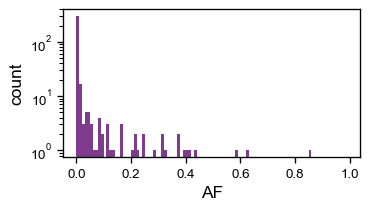

In [21]:
fig, ax = plt.subplots(1, figsize=(4, 2))
plt.hist(svs_to_keep["AF"], bins=np.arange(0, 1, 0.01))
plt.yscale("log")
plt.ylabel("count")
plt.xlabel("AF")

So there are some SVs in this region, and the vast majority are rare (unsurprisingly). We'll analyze them all together, but at some points keep rare separate.

In [22]:
(svs_to_keep["AF"] < 0.01).value_counts()

True     302
False     68
Name: AF, dtype: int64

## Extract sample dosages

Here we pull out the allele counts for each SV, so that we can determine case vs. control.

In [23]:
# we begin by subsetting the dosage matrix down to the SVs that we care about. This double counts SVs
# that affect more than one gene.
subset_dosages = dosages[dosages["ID"].isin(svs_to_keep["name"].to_list())].reset_index(
    drop=True
)

# we add in the information about which gene is affected (the first column is just the SV name, so we drop it)
subsetted_gene_dosages = (
    svs_to_keep[["name", "gene", "AF", "rare"]]
    .merge(subset_dosages, right_on="ID", left_on="name")
    .iloc[1:]
)

subsetted_gene_dosages.head(2)

,name,gene,AF,rare,#chr,start,end,ID,PT_00Y8C0XA,PT_025YMME2,PT_06Z51EN5,PT_1PA8YT1W,PT_1X6CJ589,PT_2HNFY58J,PT_2QB9MP9J,PT_2RZN4HR2,PT_397V1YW0,PT_39P91GFA,PT_4Y3P2N1P,PT_5E269C8Z,PT_5WAKHYY2,PT_7APMD0HG,PT_82D2FJV2,PT_8NPMDET9,PT_CBXEYWC5,PT_DYD0F9GP,PT_EHQ50Y19,PT_ESWCNGKM,PT_F2AFSP66,PT_F8GBEBH4,PT_FKE049G2,PT_FZ3XEWEK,PT_G1NQNTVQ,PT_GS8DC2DJ,PT_HJHZKCBX,PT_HS4P27SE,PT_J3VD4RFP,PT_JQGFY0SK,PT_K1E43YZQ,PT_KZG5PVKZ,PT_M1Z4XWW2,PT_M4ETZ912,PT_N4YDXR75,PT_NPNW1RSB,PT_P111JVHP,PT_P44YQ044,PT_PDYCQB6P,PT_PFRE83H3,PT_RVTVP55V,PT_SBS3N6ZT,...,TPMCCDG6295,TPMCCDG6311,TPMCCDG6379,TPMCCDG6405,TPMCCDG6421,TPMCCDG6659,TPMCCDG6773,TPMCCDG6978,TPMCCDG6997,TPMCCDG7107,TPMCCDG7191,TPMCCDG7220,TPMCCDG7521,TPMCCDG7553,TPMCCDG7653,TPMCCDG7655,TPMCCDG7678,TPMCCDG7773,TPMCCDG7784,TPMCCDG7849,TPMCCDG8022,TPMCCDG8128,TPMCCDG8399,TPMCCDG8529,TPMCCDG8550,TPMCCDG8609,TPMCCDG8663,TPMCCDG8711,TPMCCDG8725,TPMCCDG8762,TPMCCDG8792,TPMCCDG8801,TPMCCDG8819,TPMCCDG8862,TPMCCDG8876,TPMCCDG9065,TPMCCDG9097,TPMCCDG9139,TPMCCDG9227,TPMCCDG9240,TPMCCDG9262,TPMCCDG9290,TPMCCDG9295,TPMCCDG9357,TPMCCDG9392,TPMCCDG9464,TPMCCDG9654,TPMCCDG9683,TPMCCDG9686,TPMCCDG9902
1,PedSV.v2.0_DEL_chr2_2534,ALK,0.000940,True,chr2,28718142,28718224,PedSV.v2.0_DEL_chr2_2534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,PedSV.v2.0_INS_chr2_821,ALK,0.000072,True,chr2,28741645,28741645,PedSV.v2.0_INS_chr2_821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, we devise two metrics for cases and controls--one listing the allele frequency of each SV and another listing the number of samples with an SV in the gene.

We need to convert the dosage (allele count) to allele frequencies

In [46]:
case_control_counts = []
case_control_samples_with_svs = []

for sample_group, label in zip(
    [nbl_samples, control_samples], ["cases", "controls"]
):

    # subset to these samples
    sample_dosages = subsetted_gene_dosages[
        ["name", "gene", "#chr", "start", "end", "AF", "rare"] + sample_group
    ]

    # first, count the SVs. This function counts the number of samples with each genotype.
    sv_counts = (
        sample_dosages[sample_group]
        .apply(lambda row: row.dropna().value_counts(), axis=1)
        .fillna(0)
        .astype(int)
    )

    # name columns to genotypes
    sv_counts.columns = f"{label}_" + sv_counts.columns.astype(int).astype(str)
    sv_counts["name"] = sample_dosages["name"]

    case_control_counts.append(sv_counts)

    # now count the number of samples with at least one SV around each gene.
    # we groupby gene, then determine whether each sample has an SV in that gene, then
    # count these samples up per gene.
    num_samples_with_svs = sample_dosages.groupby(["gene"]).apply(
        lambda group: (group[sample_group] > 0).any(axis=0).sum()
    )

    num_samples_with_svs.name = label + "_all"
    num_samples_with_svs = num_samples_with_svs / len(sample_group)
    case_control_samples_with_svs.append(num_samples_with_svs)

    # repeat for rare SVs
    num_samples_with_svs_rare = (
        sample_dosages.query("rare == True")
        .groupby(["gene"])
        .apply(lambda group: (group[sample_group] > 0).any(axis=0).sum())
    )

    num_samples_with_svs_rare.name = label + "_rare"
    num_samples_with_svs_rare = num_samples_with_svs_rare / len(sample_group)
    case_control_samples_with_svs.append(num_samples_with_svs_rare)

# merge
case_control_sv_counts = sample_dosages.iloc[:, :7].reset_index(drop=True)
for df in case_control_counts:
    case_control_sv_counts = case_control_sv_counts.merge(df)

case_control_sv_counts["midpoint"] = np.mean(
    case_control_sv_counts[["start", "end"]], axis=1
)

# and total up the sample counts
case_control_sample_counts = pd.DataFrame(case_control_samples_with_svs).T

In [47]:
case_control_sv_counts.head(2)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint
0,PedSV.v2.0_DEL_chr2_2534,ALK,chr2,28718142,28718224,0.000940,True,266,0,0,2723,2,0,28718183.0
1,PedSV.v2.0_INS_chr2_821,ALK,chr2,28741645,28741645,0.000072,True,265,1,0,2720,0,0,28741645.0


Next we add some columns for allele frequency.

In [48]:
for label in ["cases", "controls"]:

    # a quick check to see if there are non-0/1/2 genotypes
    columns = [col for col in case_control_sv_counts.columns if col.startswith(label)]
    assert columns == [f"{label}_{i}" for i in range(3)]

    alt = (case_control_sv_counts[columns] * np.array([0, 1, 2])).sum(axis=1)
    ref = case_control_sv_counts[columns].sum(axis=1) * 2
    case_control_sv_counts[f"AF_{label}"] = alt / ref

In [49]:
case_control_sv_counts.head(2)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
0,PedSV.v2.0_DEL_chr2_2534,ALK,chr2,28718142,28718224,0.000940,True,266,0,0,2723,2,0,28718183.0,0.00000,0.000367
1,PedSV.v2.0_INS_chr2_821,ALK,chr2,28741645,28741645,0.000072,True,265,1,0,2720,0,0,28741645.0,0.00188,0.000000


In [50]:
case_control_sample_counts

,cases_all,cases_rare,controls_all,controls_rare
gene,,,,
ALK,1.0,0.097744,0.999633,0.099450
TERT,1.0,0.443609,1.000000,0.437798


Any smoking guns in terms of SVs?

In [51]:
freq_diff = case_control_sv_counts["AF_cases"] - (case_control_sv_counts["AF_controls"])

case_control_sv_counts.iloc[freq_diff.sort_values(ascending=False).index].query('rare == True').head(4)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
346,PedSV.v2.0_DUP_chr5_281,TERT,chr5,1623037,1623734,0.009614,True,237,15,0,2555,56,0,1623385.5,0.029762,0.010724
333,PedSV.v2.0_DUP_chr5_276,TERT,chr5,1603954,1604139,0.005786,True,251,9,0,2656,37,0,1604046.5,0.017308,0.006870
30,PedSV.v2.0_DEL_chr2_2582,ALK,chr2,29200016,29200127,0.005230,True,257,7,0,2688,23,0,29200071.5,0.013258,0.004242
143,PedSV.v2.0_DEL_chr5_348,TERT,chr5,981916,982347,0.006805,True,257,9,0,2674,47,0,982131.5,0.016917,0.008637


In [52]:
case_control_sv_counts.iloc[freq_diff.sort_values(ascending=False).index].tail(4)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
351,PedSV.v2.0_INS_chr5_51,TERT,chr5,1645658,1645658,0.394630,False,112,118,36,1049,927,736,1645658.0,0.357143,0.442294
235,PedSV.v2.0_DEL_chr5_452,TERT,chr5,1192088,1192846,0.249316,False,135,108,0,994,1650,0,1192467.0,0.222222,0.312027
358,PedSV.v2.0_DEL_chr5_572,TERT,chr5,1662952,1663184,0.316623,False,161,60,45,1325,725,675,1663068.0,0.281955,0.380734
359,PedSV.v2.0_DEL_chr5_573,TERT,chr5,1663376,1664137,0.314034,False,133,125,0,719,1886,90,1663756.5,0.242248,0.383302


## Where do these fall relative to gene regions?

Presumably, the closer they are to the gene, the more we expect them to matter. We'll just map them out on the gene locuses (I like to visualize first).

This is a little hamfisted, but we'll split by common SVs and then just rare.

In [53]:
expanded_gene_locs

,chrom,start,end,gene
TERT,chr5,753167,1795068,TERT
ALK,chr2,28692774,30421586,ALK


/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator


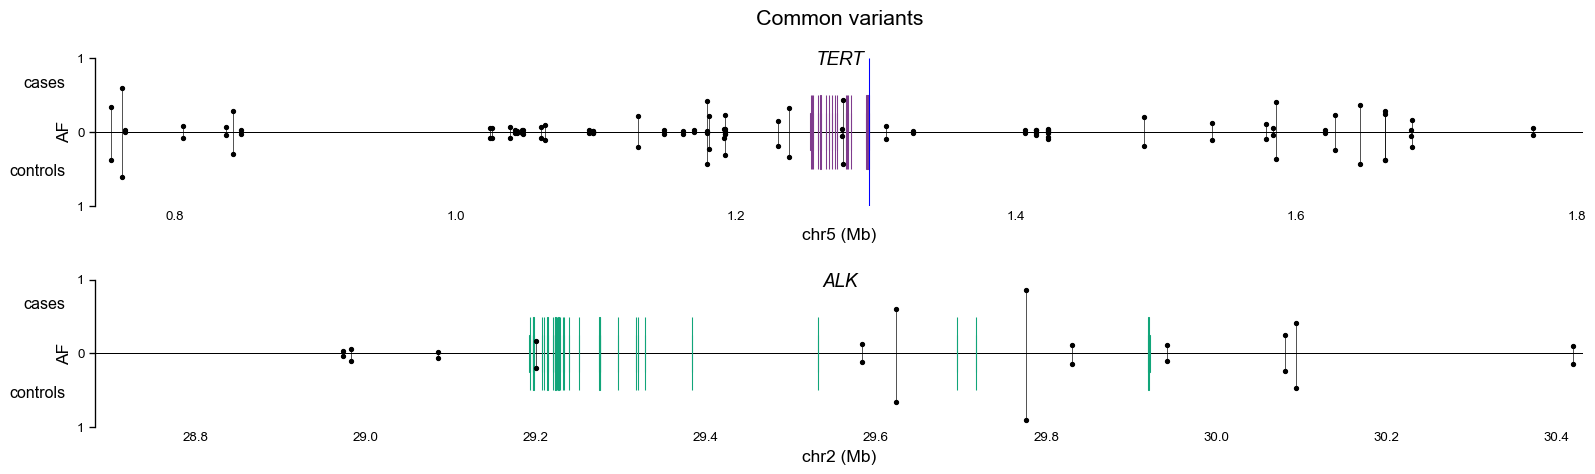

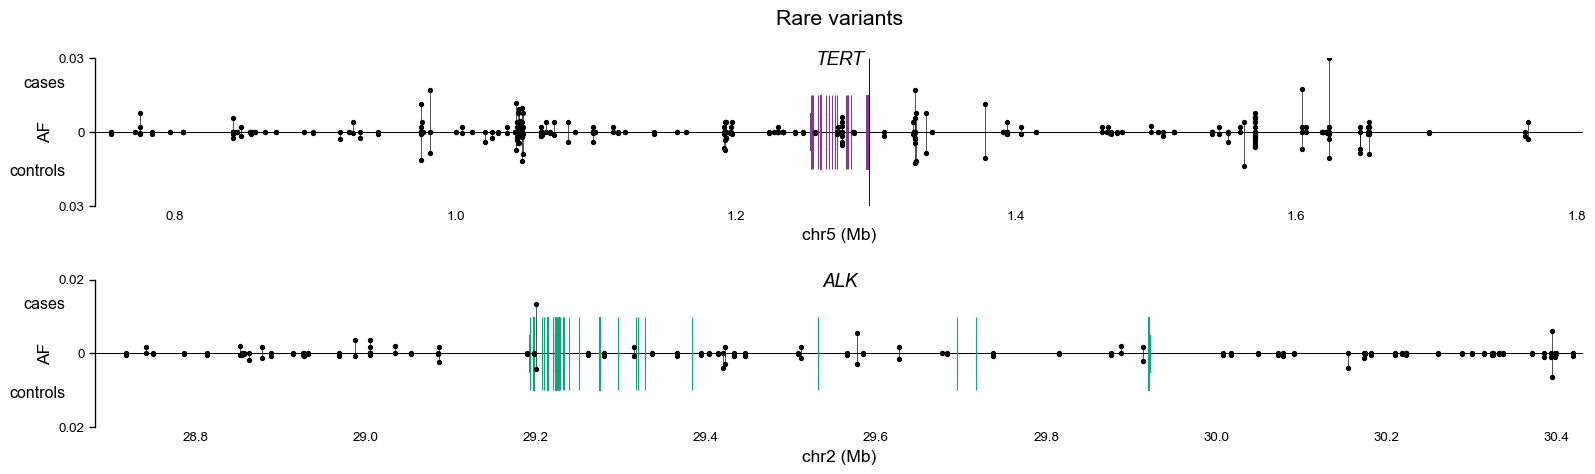

In [54]:
for plot in ["common", "rare"]:

    fig, axes = plt.subplots(
        len(expanded_gene_locs),
        1,
        figsize=(20, 2.5 * len(expanded_gene_locs)),
        gridspec_kw={"hspace": 0.5},
    )

    for i, g in enumerate(expanded_gene_locs["gene"]):

        ax = axes[i]
        g_gtf = gene_gtfs[g]

        # plot the genetic elements
        feature_colors = {"exon": bold_10[i], "CDS": bold_10[i], 'promoter': 'blue'}
        window = expanded_gene_locs.loc[g, ["start", "end"]].values
        feature_span = {"exon": 0.25, "CDS": 0.5, "promoter": 1}

        ax = sv_plot.plot_genomic_elements(
            ax,
            g_gtf,
            window=window,
            features = ('exon', 'CDS', 'promoter'),
            feature_span=feature_span,
            feature_colors=feature_colors,
            label=False,
        )
        aesthetics.strip_axis(ax=ax, x="label", y="ignore")

        contig = expanded_gene_locs.loc[g, "chrom"]
        ax.set_title(g, fontstyle="italic", y=0.9)

        # plot the range of interest
        ax.set_xlim(
            expanded_gene_locs.loc[g, ["start", "end"]].values
            + np.array([-10000, 10000])
        )
        ax.spines["bottom"].set_bounds(
            expanded_gene_locs.loc[g, ["start", "end"]].values
        )

        # add labels
        ax.text(s="cases", x=-0.02, y=0.8, transform=ax.transAxes, ha="right")
        ax.text(s="controls", x=-0.02, y=0.2, transform=ax.transAxes, ha="right")

        # switch to Mb
        ax.set_xticklabels(ax.get_xticks() / 1e6)
        ax.set_xlabel(f"{contig} (Mb)")

    # next we add in the SVs. First subset to the SVs in question
    if plot == "common":
        plot_svs = case_control_sv_counts.query("rare == False").copy()
    elif plot == "rare":
        plot_svs = case_control_sv_counts.query("rare == True").copy()

    for i, gene in enumerate(expanded_gene_locs["gene"]):

        ax = axes[i]
        gene_data = plot_svs[plot_svs["gene"] == gene]

        # get the max frequency
        max_freq = gene_data[["AF_cases", "AF_controls"]].max().max()

        if plot == "common":
            rounded_max = 1
        if plot == "rare":
            rounded_max = math.ceil(max_freq * 100) / 100

        # its much easier to plot everything at once with plt.stem, but that function sucks
        # we scale the frequency to fill the plot
        case_y = (gene_data["AF_cases"]) / rounded_max
        control_y = (gene_data["AF_controls"]) / rounded_max

        # add the points
        ax.scatter(x=gene_data["midpoint"], y=case_y, color="black", s=10, zorder=3)
        ax.scatter(x=gene_data["midpoint"], y=-control_y, color="black", s=10, zorder=3)

        # add the lollipop lines
        for loc, case, control in zip(gene_data["midpoint"], case_y, control_y):
            ax.plot(
                [loc, loc],
                [case, -control],
                color="black",
                linewidth=0.5,
                zorder=3,
            )

        ax.set_yticks([-1, 0, 1])
        ax.set_yticklabels([rounded_max, 0, rounded_max])
        ax.set_ylabel("AF")

    # add a title - can't use suptitle because that doesn't center over the gene
    axes[0].text(
        s=plot.capitalize() + " variants",
        x=0.5,
        y=1.2,
        transform=axes[0].transAxes,
        ha="center",
        va="bottom",
        fontsize=16,
    )

    fig.savefig(f"images/TERT-ALK-{plot}.png")

# A quick burden test

This is probably going to be significant, but we'll check anyway.

In [55]:
columns = [
    "entity:sample_id",
    "disease",
    "sex",
] + [col for col in metadata.columns if col in ['PC1', 'PC2', 'PC3']]

model_data = metadata[
    metadata["entity:sample_id"].isin(nbl_samples + control_samples)
][columns].set_index("entity:sample_id")

# annoying reformatting
model_data["disease"] = model_data["disease"].replace({"neuroblastoma": 1, "control": 0})

Now we determine the dosages

In [56]:
# for rare, common, and combined variants, we count
for gene in ['TERT', 'ALK']:
    for rare in [True, False, 'combined']:

        if rare in [True, False]:
            gene_svs = subsetted_gene_dosages[
                (subsetted_gene_dosages["rare"] == rare)
                & (subsetted_gene_dosages["gene"] == gene)
            ]
            label = 'rare ' + gene if rare else 'common ' + gene
        elif rare == "combined":
            gene_svs = subsetted_gene_dosages[
                (subsetted_gene_dosages["gene"] == gene)
            ]
            label = 'rare + common ' + gene

        sv_counts = (gene_svs[nbl_samples + control_samples] > 0).sum(axis=0)

        model_data.loc[sv_counts.index, label] = sv_counts

Now we run the model

In [57]:
for gene in ['TERT', 'ALK']:
    for svtype in ['rare', 'common', 'rare + common']:

        column = svtype + ' ' + gene

        # run the model
        endog = model_data["disease"]
        exog = sm.tools.add_constant(model_data[[column] + columns[2:]])
        model = sm.Logit(
            endog,
            exog,
        ).fit(disp=0)

        coeff = model.params[1]
        p = model.pvalues[1]
        print('SV burden', svtype, gene, 'coeff:', coeff, 'p:', p)

        # also try a one-hot encoding
        exog[column] = (model_data[column] > 0).astype(int)

        try:
            one_hot_model = sm.Logit(
                endog,
                exog,
            ).fit(disp=0)
        except:
            print('Model failed')
            continue

        coeff = one_hot_model.params[1]
        p = one_hot_model.pvalues[1]
        print("SV one hot", svtype, gene, 'coeff:', coeff, 'p:', p)

SV burden rare TERT coeff: 0.14667162336927228 p: 0.03920799691625853
SV one hot rare TERT coeff: 0.14660041535604285 p: 0.2862964032131915
SV burden common TERT coeff: -0.1375984935321639 p: 5.219974476776628e-09
Model failed
SV burden rare + common TERT coeff: -0.10752180040266626 p: 8.825563530899576e-07
Model failed
SV burden rare ALK coeff: 0.14961276626292383 p: 0.4793557314996292
SV one hot rare ALK coeff: 0.12719812338484285 p: 0.5808846443732598
SV burden common ALK coeff: -0.14584468605159476 p: 0.004569067445915526
SV one hot common ALK coeff: 21.33930553024867 p: 0.9999658355417872
SV burden rare + common ALK coeff: -0.13193129692633582 p: 0.008758456599500492
SV one hot rare + common ALK coeff: 21.33930553024867 p: 0.9999658355417872


/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Common SV testing with one-hot-encoding fails because some of these SVs are so common (such that the proportion of cases with at least one is 1).

But it's clear there's a rare variant signal here, which is neat.

# Individual SV analysis

Here we'll go through each SV and run a logit model, incorporating the same variables above, except time we'll use genotype.

In [58]:
columns = [
    "entity:sample_id",
    "disease",
    "sex",
] + ['PC1', 'PC2', 'PC3']

model_data = metadata[
    metadata["entity:sample_id"].isin(nbl_samples + control_samples)
][columns].set_index("entity:sample_id")

# annoying reformatting
model_data["disease"] = model_data["disease"].replace({"neuroblastoma": 1, "control": 0})

In [59]:
model_data['disease'].value_counts()

0    2725
1     266
Name: disease, dtype: int64

Now we add the genotypes to this model data.

In [60]:
sv_dosages = subsetted_gene_dosages.set_index("name")[nbl_samples + control_samples]
model_data.loc[sv_dosages.columns, list(sv_dosages.index)] = sv_dosages.T

Next we simply loop through the SVs and run the model.

In [61]:
sv_models = {}
sv_results = []

for sv in sv_dosages.index:

    sv_model_data = model_data[columns[1:] + [sv]]

    # drop samples that could not be genotyped. This inherently introduces bias, so we keep track of the number of samples dropped.
    sv_model_data_nonna = sv_model_data.dropna(subset=[sv]).copy()
    dropped_samples = set(sv_model_data.index) - set(sv_model_data_nonna.index)
    num_cases_dropped = len(set(nbl_samples) & dropped_samples)
    num_controls_dropped = len(set(control_samples) & dropped_samples)

    # statsmodels doesn

    # run the model
    try:
        endog = sv_model_data_nonna["disease"]
        exog = sm.tools.add_constant(sv_model_data_nonna[[sv] + columns[2:]])

        # suppress some failure warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model = sm.Logit(
                endog=endog,
                exog=exog,
            ).fit(disp=0, method="bfgs", maxiter=1000)

        # store
        sv_models[sv] = model
        sv_results.append(
            [
                sv,
                model.pvalues[1],
                model.params[1],
                num_cases_dropped,
                num_controls_dropped,
            ]
        )

    except:
        sv_models[sv] = "fail"

sv_results = pd.DataFrame(
    sv_results,
    columns=["name", "p", "coeff", "num_cases_dropped", "num_controls_dropped"],
).set_index("name")

In [62]:
sv_results.head(2)

,p,coeff,num_cases_dropped,num_controls_dropped
name,,,,
PedSV.v2.0_DEL_chr2_2534,0.788910,-1.63349,0,0
PedSV.v2.0_INS_chr2_821,0.605002,6.72508,0,5


In [63]:
case_control_sv_counts = case_control_sv_counts.merge(sv_results.reset_index()[['name', 'p', 'coeff']], on = ['name'])

In [64]:
case_control_sv_counts.query('gene == "TERT" & p < 0.05')

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls,p,coeff
99,PedSV.v2.0_DUP_chr5_150,TERT,chr5,736380,1117748,0.000362,True,263,2,0,2722,2,0,927064.0,0.003774,0.000367,1.935022e-03,3.314429
100,PedSV.v2.0_DUP_chr5_154,TERT,chr5,754062,754618,0.371108,False,98,158,10,950,1438,336,754340.0,0.334586,0.387298,6.837963e-03,-0.299041
106,PedSV.v2.0_DEL_chr5_295,TERT,chr5,774516,774657,0.001302,True,262,4,0,2723,2,0,774586.5,0.007519,0.000367,1.901671e-03,2.901796
143,PedSV.v2.0_DEL_chr5_348,TERT,chr5,981916,982347,0.006805,True,257,9,0,2674,47,0,982131.5,0.016917,0.008637,3.703396e-02,0.816032
148,PedSV.v2.0_DEL_chr5_356,TERT,chr5,1022704,1026579,0.056843,False,236,25,0,1999,436,0,1024641.5,0.047893,0.089528,1.264742e-02,-0.579660
150,PedSV.v2.0_DEL_chr5_357,TERT,chr5,1026174,1026245,0.044086,False,230,23,0,2074,392,0,1026209.5,0.045455,0.079481,1.639199e-02,-0.560447
176,PedSV.v2.0_DUP_chr5_196,TERT,chr5,1045489,1045576,0.003977,True,261,5,0,2701,24,0,1045532.5,0.009398,0.004404,4.579773e-03,1.531115
186,PedSV.v2.0_DUP_chr5_205,TERT,chr5,1046895,1047096,0.000508,True,264,1,0,2716,2,0,1046995.5,0.001887,0.000368,1.962170e-02,3.170471
187,PedSV.v2.0_DUP_chr5_206,TERT,chr5,1047038,1047793,0.002316,True,258,5,0,2649,12,0,1047415.5,0.009506,0.002255,3.991976e-02,1.146196
203,PedSV.v2.0_DEL_chr5_405,TERT,chr5,1064918,1065021,0.001101,True,259,2,0,2703,1,0,1064969.5,0.003831,0.000185,2.118671e-02,2.841279


So there's a lot of activity around TERT. Let's see where it localizes.

We load in the discovery cohort here as well.

In [88]:
discovery = pd.read_csv('data/tert-alk-discovery-cohort-significant-loci-v2.1.csv')
merged_dis_val = case_control_sv_counts.merge(discovery[['name', 'p', 'coeff']], 
                                              on = ['name'], suffixes = ['_validation', '_discovery'])
validated_hits = merged_dis_val.query('p_discovery < 0.000125 & p_validation < 0.05')

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


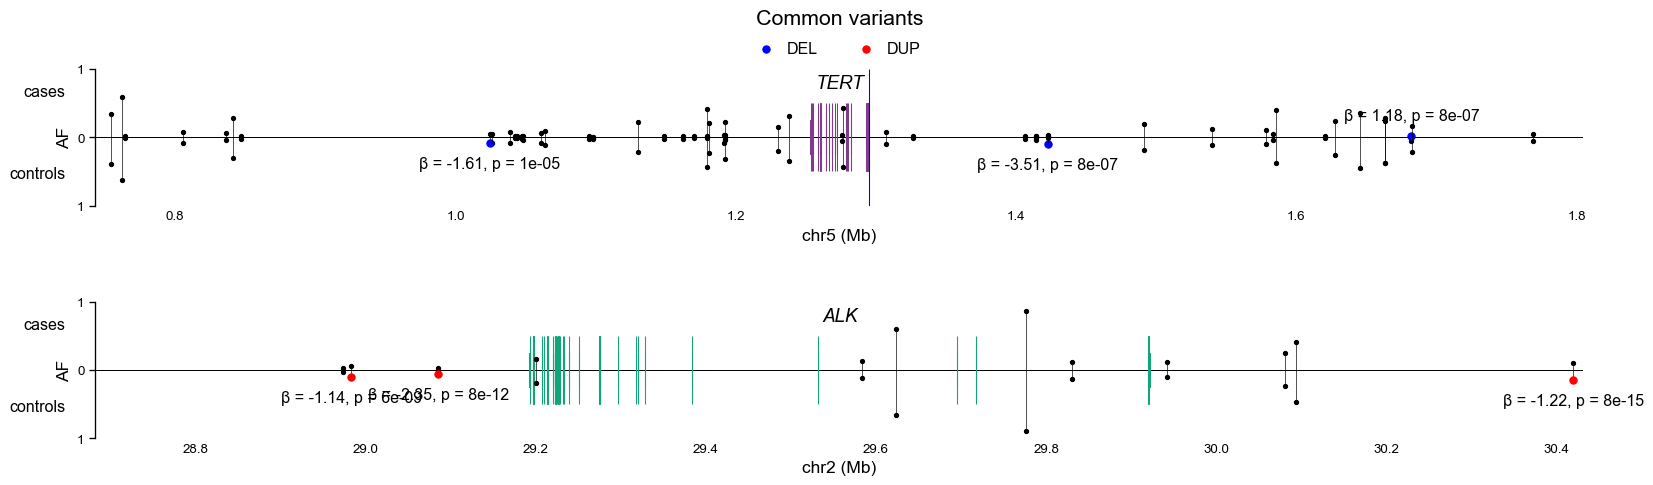

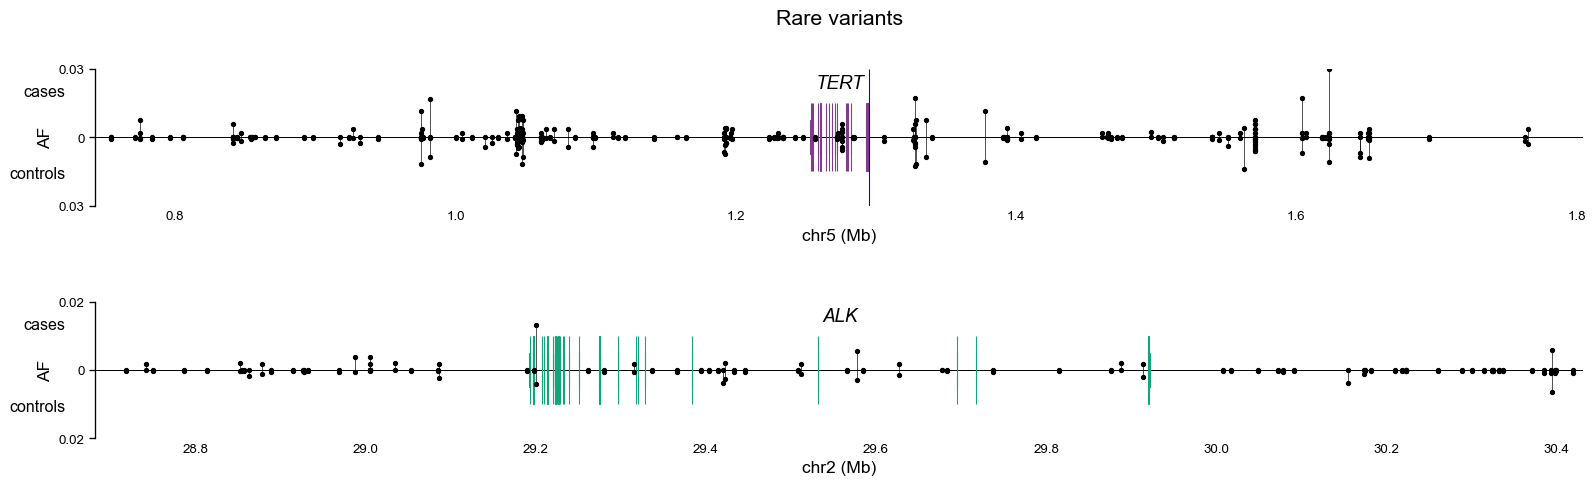

In [89]:
sv_colors = {"DEL": "blue", "DUP": "red", "INS": bold_10[0], 'CPX': 'green'}

for plot in ["common", "rare"]:

    fig, axes = plt.subplots(
        len(expanded_gene_locs),
        1,
        figsize=(20, 2.5 * len(expanded_gene_locs)),
        gridspec_kw={"hspace": 0.7},
    )

    for i, g in enumerate(expanded_gene_locs["gene"]):

        ax = axes[i]
        g_gtf = gene_gtfs[g]

        # plot the genetic elements
        feature_colors = {"exon": bold_10[i], "CDS": bold_10[i], 'promoter': 'blue'}
        window = expanded_gene_locs.loc[g, ["start", "end"]].values
        feature_span = {"exon": 0.25, "CDS": 0.5, 'promoter': 1}

        ax = sv_plot.plot_genomic_elements(
            ax,
            g_gtf,
            window=window,
            features=['exon', 'CDS', 'promoter'],
            feature_span=feature_span,
            feature_colors=feature_colors,
            label=False,
        )
        aesthetics.strip_axis(ax=ax, x="label", y="ignore")

        contig = expanded_gene_locs.loc[g, "chrom"]
        ax.set_title(g, fontstyle="italic", y=0.80)

        # plot the range of interest
        ax.set_xlim(
            expanded_gene_locs.loc[g, ["start", "end"]].values
            + np.array([-10000, 10000])
        )
        ax.spines["bottom"].set_bounds(
            expanded_gene_locs.loc[g, ["start", "end"]].values
        )

        # add labels
        ax.text(s="cases", x=-0.02, y=0.8, transform=ax.transAxes, ha="right")
        ax.text(s="controls", x=-0.02, y=0.2, transform=ax.transAxes, ha="right")

        # switch to Mb
        ax.set_xticklabels(ax.get_xticks() / 1e6)
        ax.set_xlabel(f"{contig} (Mb)")

    # next we add in the SVs. First subset to the SVs in question
    if plot == "common":
        plot_svs = case_control_sv_counts.query("rare == False").copy()
    elif plot == "rare":
        plot_svs = case_control_sv_counts.query("rare == True").copy()

    legend_handles = {}
    for i, gene in enumerate(expanded_gene_locs["gene"]):

        ax = axes[i]
        gene_data = plot_svs[plot_svs["gene"] == gene].reset_index()

        # get the max frequency
        max_freq = gene_data[["AF_cases", "AF_controls"]].max().max()

        if plot == "common":
            rounded_max = 1
        if plot == "rare":
            rounded_max = math.ceil(max_freq * 100) / 100

        # its much easier to plot everything at once with plt.stem, but that function sucks
        # we scale the frequency to fill the plot
        case_y = (gene_data["AF_cases"]) / rounded_max
        control_y = (gene_data["AF_controls"]) / rounded_max

        # add the points
        ax.scatter(x=gene_data["midpoint"], y=case_y, color="black", s=10, zorder=3)
        ax.scatter(x=gene_data["midpoint"], y=-control_y, color="black", s=10, zorder=3)

        # add the lollipop lines
        for j in range(len(gene_data)):
            loc = gene_data["midpoint"][j]
            name = gene_data["name"][j]

            case, control = case_y[j], control_y[j]

            ax.plot(
                [loc, loc],
                [case, -control],
                color="black",
                linewidth=0.5,
                zorder=3,
            )

            # look up the p value of the sv, if it exists
            if name in validated_hits['name'].to_list():
                p_val, coeff = merged_dis_val.set_index('name').loc[name, ["p_discovery", "coeff_discovery"]]

                if p_val < 0.05:

                    y = case if coeff > 0 else -control
                    text_y = y + 0.3 if coeff > 0 else y - 0.3

                    sv_type = svs_to_keep.set_index("name").loc[name, "svtype"]
                    color = sv_colors.get(sv_type)

                    scatter = ax.scatter(
                        [loc], [y], color=color, s=30, zorder=3, label=sv_type
                    )

                    if sv_type in ["DUP", "DEL", "CPX", "INS"]:
                        legend_handles[sv_type] = scatter

                    # add text for coeff
                    ax.text(
                        x=loc,
                        y=text_y,
                        s=f"β = {round(coeff, 2)}, p = {p_val:.1}",
                        ha="center",
                        va="center",
                    )

        ax.set_yticks([-1, 0, 1])
        ax.set_yticklabels([rounded_max, 0, rounded_max])
        ax.set_ylabel("AF")

    # add a title - can't use suptitle because that doesn't center over the gene
    axes[0].text(
        s=plot.capitalize() + " variants",
        x=0.5,
        y=1.3,
        transform=axes[0].transAxes,
        ha="center",
        va="bottom",
        fontsize=16,
    )

    axes[0].legend(
        handles=legend_handles.values(),
        labels=legend_handles.keys(),
        bbox_to_anchor=(0.43, 1.15),
        ncol=2,
        handletextpad=0.3,
    )

    fig.savefig(f"images/TERT-ALK-significance-{plot}.png")